###  Modèle type LeNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data_detour = pd.read_csv('../files_detour.csv',index_col=0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31735 entries, 0 to 31734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  31735 non-null  object
 1   filename   31735 non-null  object
 2   class      31735 non-null  object
dtypes: object(3)
memory usage: 991.7+ KB


In [5]:
data_detour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31603 entries, 0 to 31602
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      31603 non-null  int64 
 1   file_path  31603 non-null  object
 2   filename   31603 non-null  object
 3   class      31603 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
# Garde seulement les images où le détourage possible pour comparaison avec/sans détourage
data = data[data['filename'].isin(data_detour['filename'])]

In [7]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [8]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [9]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [10]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [11]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) 
    img = tf.cast(img, tf.float32)/255
    return img

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [14]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [15]:
# Création d'un modèle CNN type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=10,activation='softmax')) #10 Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model = model_CNN()

In [17]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 1397s 2s/step - loss: 1.1873 - accuracy: 0.5853 - val_loss: 0.6490 - val_accuracy: 0.7796
Epoch 2/16
800/800 [==============================] - 1366s 2s/step - loss: 0.6370 - accuracy: 0.7877 - val_loss: 0.5552 - val_accuracy: 0.8053
Epoch 3/16
800/800 [==============================] - 1437s 2s/step - loss: 0.5009 - accuracy: 0.8335 - val_loss: 0.4727 - val_accuracy: 0.8401
Epoch 4/16
800/800 [==============================] - 1294s 2s/step - loss: 0.4175 - accuracy: 0.8610 - val_loss: 0.4573 - val_accuracy: 0.8541
Epoch 5/16
800/800 [==============================] - 1245s 2s/step - loss: 0.3421 - accuracy: 0.8870 - val_loss: 0.4348 - val_accuracy: 0.8562
Epoch 6/16
800/800 [==============================] - 1245s 2s/step - loss: 0.2751 - accuracy: 0.9075 - val_loss: 0.4442 - val_accuracy: 0.8696
Epoch 7/16
800/800 [==============================] - 1270s 2s/step - loss: 0.2142 - accuracy: 0.9285 - val_loss: 0.4603 - val_accuracy:

#### Prédiction sur les données d'évaluation

In [18]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [19]:
model.evaluate(dataset_eval)

99/99 [==============================] - 41s 412ms/step - loss: 0.4531 - accuracy: 0.8507


[0.45310884714126587, 0.8506801724433899]

 * Score de 85%

In [20]:
#Classes prédites
predict = model.predict(dataset_eval)

In [21]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.81      0.88      0.84       119
       blast       0.75      0.92      0.83       327
  eosinophil       0.97      0.94      0.95       323
erythroblast       0.93      0.80      0.86       210
          ig       0.77      0.65      0.71       381
  lymphocyte       0.84      0.92      0.88       453
    monocyte       0.73      0.81      0.77       274
  neutrophil       0.92      0.91      0.91       573
    platelet       0.98      0.97      0.97       242
      smudge       0.80      0.66      0.73       259

    accuracy                           0.85      3161
   macro avg       0.85      0.85      0.85      3161
weighted avg       0.85      0.85      0.85      3161



> Rappel plus faible sur les IG toujours, ainsi que les monocytes
>
> Score plus faible sur blast et smudge, compréhensible par des différences importantes sur ces types

In [22]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,105,0,0,0,8,2,2,1,0,1
blast,0,300,0,0,7,1,14,0,0,5
eosinophil,5,3,303,0,1,0,0,8,0,3
erythroblast,0,0,0,168,3,25,5,6,3,0
ig,16,41,0,0,249,10,38,10,0,17
lymphocyte,0,16,1,6,1,416,8,1,0,4
monocyte,1,22,0,0,12,3,223,4,0,9
neutrophil,3,2,2,0,30,11,2,519,1,3
platelet,0,0,0,6,0,1,0,1,234,0


> Confusion importante monocyte/IG, monocyte/blast

In [23]:
model.save_weights("cnn_10_weights")

In [24]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [25]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

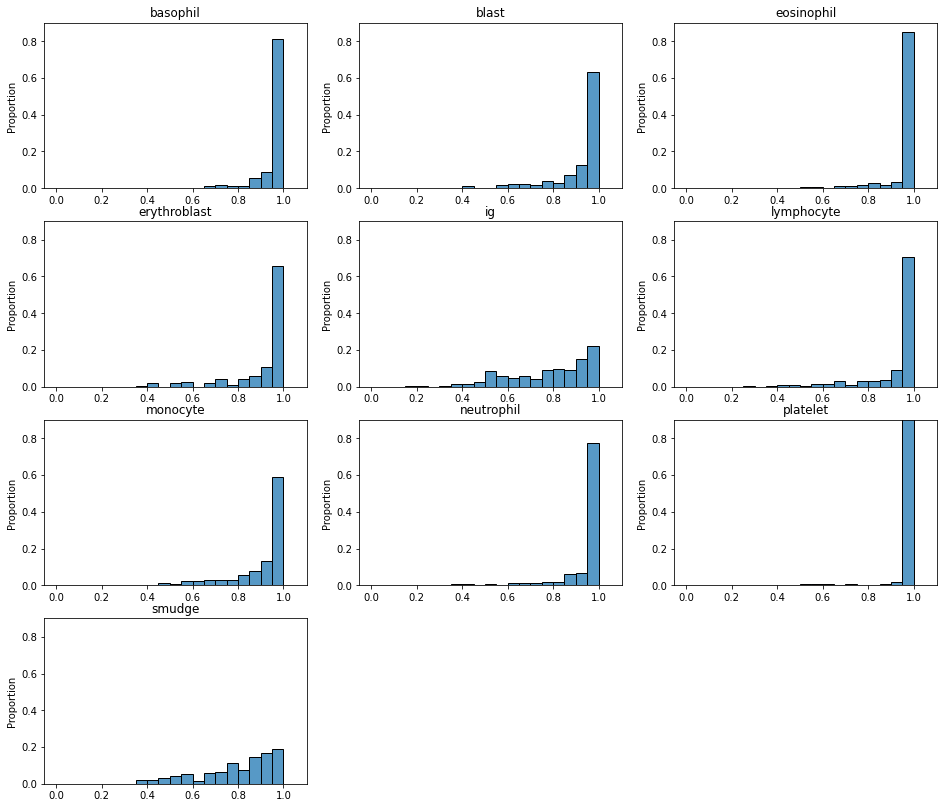

In [26]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [27]:
import gradcam_dataset

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [29]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

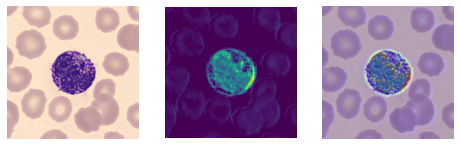

In [30]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

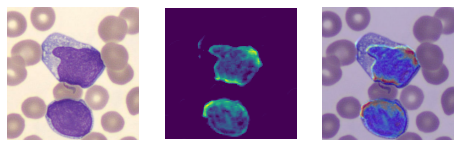

In [31]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

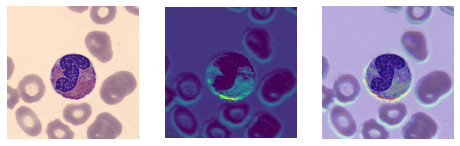

In [32]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

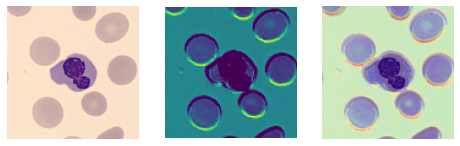

In [33]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

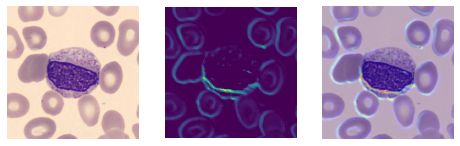

In [34]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

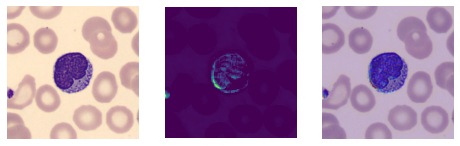

In [35]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

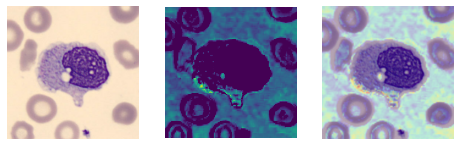

In [36]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

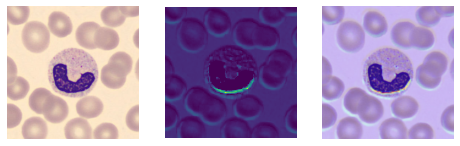

In [37]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

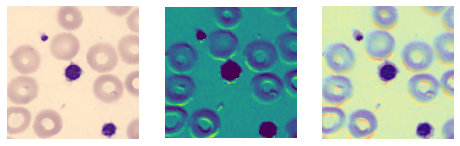

In [38]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

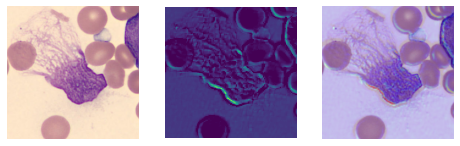

In [39]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)